# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

# Load data

In [2]:
filter_dates = [20191220, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20191227_bsf_10runs_e1_n2_train_mass_ss/v19
    20191227_bsf_10runs_e1_n2_train_mass_ss/v11
    20191227_bsf_10runs_e2_n2_train_mass_ss/v19
    20191227_bsf_10runs_e2_n2_train_mass_ss/v11
    20191227_bsf_10runs_e1_n2_train_mass_kc/v19
    20191227_bsf_10runs_e1_n2_train_mass_kc/v11
    20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_0
    20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_128
    20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_128
    20200407_attention_grid_n2_train_mass_ss/att01_d_256_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_0
    20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_128
    20200408_att03_grid_n2_train_mass_ss/att03_d_256_h_8_fc_128
    20200409_attention_grid_n2_train_mass_kc/att01_d_512_h_8_fc_0
    20200409_attention_grid_n2_train_mass_kc/att01_d_512_h_8_fc_128
    20200409_attention_grid_n2_train_mass_

In [8]:
dataset_name = constants.MASS_SS_NAME
fs = 200
which_expert = 1
task_mode = constants.N2_RECORD
seed_id_list = [i for i in range(10)]
set_list = [constants.VAL_SUBSET, constants.TRAIN_SUBSET]

# Specify what to load
comparison_runs_list = [
    ('20191227_bsf_10runs_e1_n2_train_mass_ss/v11', 'RED-Time'),
    ('20191227_bsf_10runs_e1_n2_train_mass_ss/v19', 'RED-CWT'),
    ('20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5', 'Time+CWT'),
    # ('20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5', 'Mix (width 0.5)'),
    # ('20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_1.0', 'Mix (width 1.0)'),
    # ('20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_1.5', 'Mix (width 1.5)')
    # ('20191227_bsf_10runs_e1_n2_train_mass_kc/v11', 'RED-Time'),
    # ('20200407_attention_grid_n2_train_mass_ss/att01_d_512_h_8_fc_0', 'ATT01'),
    # ('20200409_attention_grid_n2_train_mass_kc/att01_d_512_h_8_fc_0', 'ATT01'),
    # ('20200408_att03_grid_n2_train_mass_ss/att03_d_512_h_8_fc_0', 'ATT03'),
    # ('20200409_att03_grid_n2_train_mass_kc/att03_d_512_h_8_fc_0', 'ATT03'),
    # ('20200410_att04_task_pe_grid_n2_train_mass_ss/att04_pe_10000', 'ATT04'), <- este no
    # ('20200409_att04_head_grid_n2_train_mass_ss/att04_h_08', 'ATT04'),
    # ('20200410_att04_task_pe_grid_n2_train_mass_kc/att04_pe_10000', 'ATT04'),
]
comparison_runs_list = [
    (t_folder, t_label) for (t_folder, t_label) in comparison_runs_list if dataset_name in t_folder
]
ckpt_folder_list = [t_folder for (t_folder, t_label) in comparison_runs_list]
ckpt_label_dict = {t_folder: t_label for (t_folder, t_label) in comparison_runs_list}

# Load data
n_cases = len(comparison_runs_list)
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
predictions_dict = {}
for ckpt_folder in ckpt_folder_list:
    predictions_dict[ckpt_folder] = reader.read_prediction_with_seeds(
        ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed3
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed4
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191227_bsf_10runs_e1_n2_train_mass_ss/v11/seed5
Loaded /home/ntapia/projects/repo

In [9]:
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
result_id = '%s-%s-E%d-%s' % (
    dataset_name.split('_')[0].upper(), 
    dataset_name.split('_')[1].upper(), 
    which_expert,
    task_mode.upper())

In [10]:
expert_data_dict = reader.load_ss_expert_performance()
exp_keys = list(expert_data_dict.keys())
print('\nAvailable data:')
pprint(exp_keys)


Available data:
['iou_curve_axis', 'f1_vs_iou_mean', 'f1_vs_iou_std', 'recall', 'precision']


# Performance

In [11]:
# Performance
data_dict = {}
for ckpt_folder in ckpt_folder_list:
    print(ckpt_label_dict[ckpt_folder])
    t_data_dict = performer.performance_vs_iou_with_seeds(
        dataset,
        predictions_dict[ckpt_folder],
        OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder],
        iou_curve_axis,
        iou_hist_bins,
        task_mode,
        which_expert,
        set_name=constants.VAL_SUBSET
    )
    
    # Mean performance
    print('Val AF1: %1.2f +- %1.2f' % (
        100 * t_data_dict[constants.MEAN_AF1].mean(), 100 * t_data_dict[constants.MEAN_AF1].std()
    ))
    print('Val Mean IoU at TP: %1.2f +- %1.2f' % (
        100 * t_data_dict[constants.MEAN_IOU].mean(), 100 * t_data_dict[constants.MEAN_IOU].std()
    ))
    
    data_dict[ckpt_folder] = t_data_dict
    print("")

RED-Time
Val AF1: 67.63 +- 3.07
Val Mean IoU at TP: 84.23 +- 1.68

RED-CWT
Val AF1: 68.00 +- 2.65
Val Mean IoU at TP: 84.18 +- 1.54

Time+CWT
Val AF1: 67.54 +- 3.28
Val Mean IoU at TP: 83.91 +- 1.73



Database: mass_ss, Expert: 1
IoU to show: 0.2
F1 80.21/2.42, Recall 82.03/5.34, Precision 80.49/7.00, AF1 67.63/3.07, IoU 84.23/1.68 for RED-Time
F1 80.72/2.05, Recall 82.35/3.55, Precision 80.62/5.60, AF1 68.00/2.65, IoU 84.18/1.54 for RED-CWT
F1 80.38/2.60, Recall 82.90/5.02, Precision 79.91/7.37, AF1 67.54/3.28, IoU 83.91/1.73 for Time+CWT


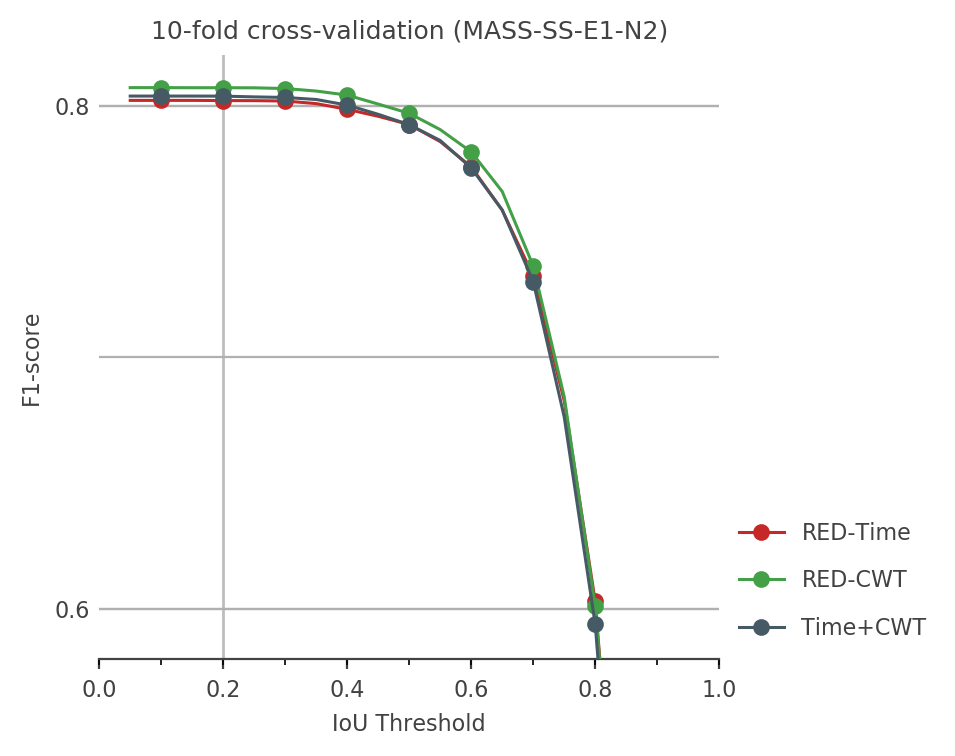

In [16]:
color_list = [viz.PALETTE['red'], viz.PALETTE['green'], viz.PALETTE['grey'], viz.PALETTE['blue'], viz.PALETTE['dark']]
# color_list = [viz.PALETTE['red'], viz.PALETTE['blue']]
marker_list = 5 * ['o']
alpha_line_list = 5 * [1]
zorder_list = 5 * [20]
idx_to_remove = []
# idx_to_remove = [0]

# Plot f1 vs iou specs
smaller_plot = False
external_legend = True
show_seed_std = False
print_formatted_table = False
zoom_plot = True
compare_expert = False
zoom_f1 = [0.58, 0.82]
alpha_seed_std = 0.4
alpha_expert = 0.5
iou_thr_to_show = 0.2
figsize = (4, 4)
title = '%d-fold cross-validation (%s)' % (len(seed_id_list), result_id)

# -------------------- P L O T ----------------------  
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('IoU to show: %1.1f' % iou_thr_to_show)
this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)

# Expert
if compare_expert and (dataset.event_name == constants.SPINDLE):
    exp_mean_f1 = expert_data_dict['%s_mean' % constants.F1_VS_IOU]
    exp_std_f1 = expert_data_dict['%s_std' % constants.F1_VS_IOU]
    exp_iou_axis = expert_data_dict[constants.IOU_CURVE_AXIS]
    min_border = exp_mean_f1 - exp_std_f1
    max_border = exp_mean_f1 + exp_std_f1
    denser_iou, max_border = plotter.densify_curve(exp_iou_axis, max_border)
    denser_iou, min_border = plotter.densify_curve(exp_iou_axis, min_border)
    ax.fill_between(
        denser_iou, min_border, max_border, alpha=alpha_expert, facecolor=viz.GREY_COLORS[6], 
        label='Expert Performance\nWarby et al. 2014\nPrivate Dataset')

for i, ckpt_folder in enumerate(ckpt_folder_list):
    if i in idx_to_remove:
        continue
    this_label = ckpt_label_dict[ckpt_folder]
    this_marker = marker_list[i]
    this_alpha = alpha_line_list[i]
    this_color = color_list[i]
    this_zorder = zorder_list[i]
    model_data_dict = data_dict[ckpt_folder]
    mean_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].mean(axis=0)
    std_f1_vs_iou = model_data_dict[constants.F1_VS_IOU].std(axis=0)
    ax.plot(
        iou_curve_axis, mean_f1_vs_iou, linewidth=viz.LINEWIDTH, zorder=this_zorder, label=this_label,
        markersize=viz.MARKERSIZE, markevery=(1, 2),
        marker=this_marker, color=this_color, alpha=this_alpha
    )
    if show_seed_std:
        ax.fill_between(
            iou_curve_axis, mean_f1_vs_iou - std_f1_vs_iou, mean_f1_vs_iou + std_f1_vs_iou, 
            alpha=alpha_seed_std, facecolor=this_color, zorder=this_zorder)
    printer.print_performance_at_iou(model_data_dict, iou_thr_to_show, this_label)
    
if print_formatted_table:
    print("")
    for i, ckpt_folder in enumerate(ckpt_folder_list):
        printer.print_formatted_performance_at_iou(
            data_dict[ckpt_folder], 
            iou_thr_to_show, 
            ckpt_label_dict[ckpt_folder], 
            print_header=(i==0))

ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
lg = plotter.format_legend(ax, external_legend, remove_alpha=(not compare_expert))
if zoom_plot:
    ax.set_ylim(zoom_f1)
lg = plotter.set_legend_color(lg)
ax = plotter.set_axis_color(ax)
plt.show()

# more stuff

In [73]:
chosen_seed = 3
model_1 = {'name': 'RED-CWT', 'ckpt': '20191227_bsf_10runs_e1_n2_train_mass_ss/v11'}
model_2 = {'name': 'Time+CWT', 'ckpt': '20200502_timePLUScwt_fb_10runs_e1_n2_train_mass_ss/v35_fb_0.5'}

In [74]:
set_name = 'val'

val_ids = ids_dict[chosen_seed][set_name]
opt_thr_1 = OPTIMAL_THR_FOR_CKPT_DICT[model_1['ckpt']][chosen_seed]
opt_thr_2 = OPTIMAL_THR_FOR_CKPT_DICT[model_2['ckpt']][chosen_seed]
preds_1 = predictions_dict[model_1['ckpt']][chosen_seed][set_name]
preds_2 = predictions_dict[model_2['ckpt']][chosen_seed][set_name]
preds_1.set_probability_threshold(opt_thr_1)
preds_2.set_probability_threshold(opt_thr_2)
dets_1 = preds_1.get_stamps()
dets_2 = preds_2.get_stamps()
probas_1 = preds_1.get_probabilities()
probas_2 = preds_2.get_probabilities()
subset_data = FeederDataset(dataset, val_ids, task_mode, which_expert=which_expert)
events = subset_data.get_stamps()
signals = subset_data.get_signals(normalize_clip=False)

In [75]:
matching_data_1 = []
matching_data_2 = []
matching_data_vs = []
for i, single_id in enumerate(val_ids):
    s_events = events[i]
    s_dets_1 = dets_1[i]
    s_dets_2 = dets_2[i]
    s_iou_matching_1, s_idx_matching_1 = metrics.matching(s_events, s_dets_1)
    matching_data_1.append({'iou': s_iou_matching_1, 'idx': s_idx_matching_1})
    s_iou_matching_2, s_idx_matching_2 = metrics.matching(s_events, s_dets_2)
    matching_data_2.append({'iou': s_iou_matching_2, 'idx': s_idx_matching_2})
    s_iou_matching_vs, s_idx_matching_vs = metrics.matching(s_dets_1, s_dets_2)
    matching_data_vs.append({'iou': s_iou_matching_vs, 'idx': s_idx_matching_vs})

# Escalares

In [76]:
# Desempeño por sujeto a IoU 0.2
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('Seed %d' % chosen_seed)
for i, single_id in enumerate(val_ids):
    n_events = events[i].shape[0]
    print("")
    print('Subject %02d (%d events)' % (single_id, n_events))
    # Scalar for model 1
    print('Report for %s (IoU >= 0.2)' % model_1['name'])
    n_detections = dets_1[i].shape[0]
    iou_match = matching_data_1[i]['iou'][matching_data_1[i]['idx'] != -1]    
    tp = np.sum((iou_match >= 0.2).astype(int))
    fp = n_detections - tp
    fn = n_events - tp
    precision = tp / n_detections
    recall = tp / n_events
    f1_score = 2 * tp / (n_detections + n_events)
    print('TP %03d - FP %03d - FN %03d' % (tp, fp, fn))
    print('F1 %1.2f - Precision %1.2f - Recall %1.2f' % (f1_score, precision, recall))
    mean_iou = 100 * iou_match.mean()
    low_iqr = 100 * np.percentile(iou_match, 25)
    high_iqr = 100 * np.percentile(iou_match, 75)
    print('IoU of Matchings %1.2f [%1.2f - %1.2f]' % (mean_iou, low_iqr, high_iqr))
    
    # Scalar for model 2
    print('Report for %s (IoU >= 0.2)' % model_2['name'])
    n_detections = dets_2[i].shape[0]
    iou_match = matching_data_2[i]['iou'][matching_data_2[i]['idx'] != -1]
    tp = np.sum((iou_match >= 0.2).astype(int))
    fp = n_detections - tp
    fn = n_events - tp
    precision = tp / n_detections
    recall = tp / n_events
    f1_score = 2 * tp / (n_detections + n_events)
    print('TP %03d - FP %03d - FN %03d' % (tp, fp, fn))
    print('F1 %1.2f - Precision %1.2f - Recall %1.2f' % (f1_score, precision, recall))
    mean_iou = 100 * iou_match.mean()
    low_iqr = 100 * np.percentile(iou_match, 25)
    high_iqr = 100 * np.percentile(iou_match, 75)
    print('IoU of Matchings %1.2f [%1.2f - %1.2f]' % (mean_iou, low_iqr, high_iqr))

Database: mass_ss, Expert: 1
Seed 3

Subject 01 (1044 events)
Report for RED-CWT (IoU >= 0.2)
TP 855 - FP 071 - FN 189
F1 0.87 - Precision 0.92 - Recall 0.82
IoU of Matchings 86.37 [82.41 - 92.10]
Report for Time+CWT (IoU >= 0.2)
TP 850 - FP 064 - FN 194
F1 0.87 - Precision 0.93 - Recall 0.81
IoU of Matchings 86.18 [82.09 - 92.31]

Subject 05 (341 events)
Report for RED-CWT (IoU >= 0.2)
TP 198 - FP 020 - FN 143
F1 0.71 - Precision 0.91 - Recall 0.58
IoU of Matchings 85.80 [80.72 - 92.46]
Report for Time+CWT (IoU >= 0.2)
TP 201 - FP 021 - FN 140
F1 0.71 - Precision 0.91 - Recall 0.59
IoU of Matchings 85.54 [80.92 - 92.11]

Subject 10 (793 events)
Report for RED-CWT (IoU >= 0.2)
TP 727 - FP 158 - FN 066
F1 0.87 - Precision 0.82 - Recall 0.92
IoU of Matchings 85.78 [81.68 - 92.38]
Report for Time+CWT (IoU >= 0.2)
TP 732 - FP 153 - FN 061
F1 0.87 - Precision 0.83 - Recall 0.92
IoU of Matchings 86.42 [82.40 - 92.53]


# Durations

In [77]:
def find_durations(data_x, data_y):
    matched_real_idx = np.where(idx_matching > -1)[0]
    matched_det_idx = idx_matching[idx_matching > -1]
    matched_real_event = data_x[i][matched_real_idx]
    matched_det_event = data_y[i][matched_det_idx]
    matched_real_dur = matched_real_event[:, 1] - matched_real_event[:, 0]
    matched_det_dur = matched_det_event[:, 1] - matched_det_event[:, 0]
    return matched_real_dur, matched_det_dur

Database: mass_ss, Expert: 1
Seed 3


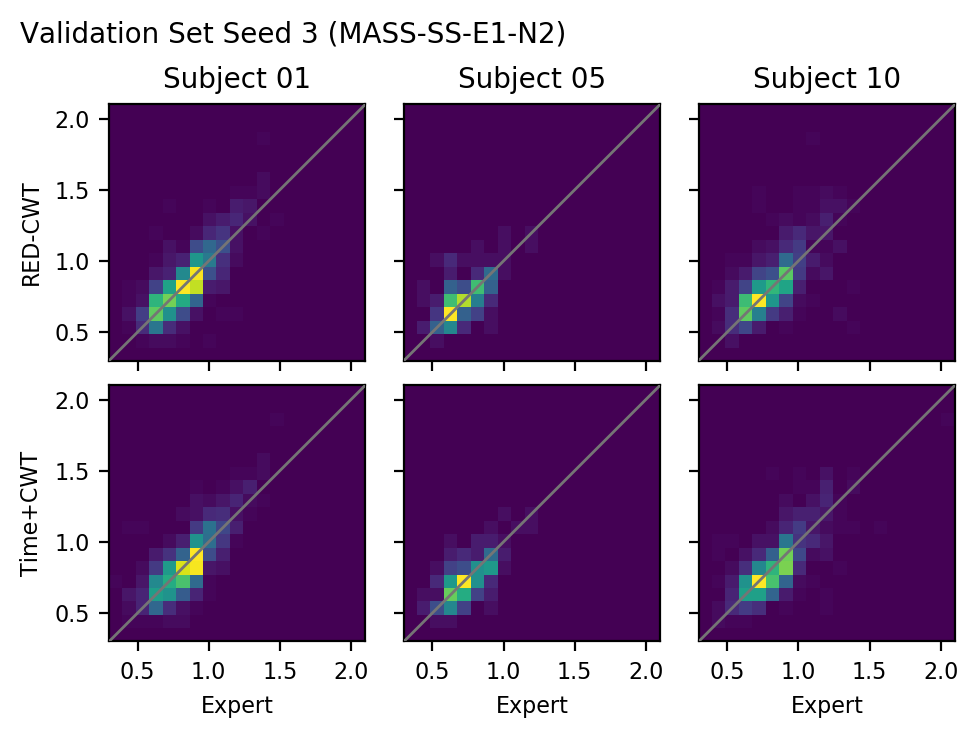

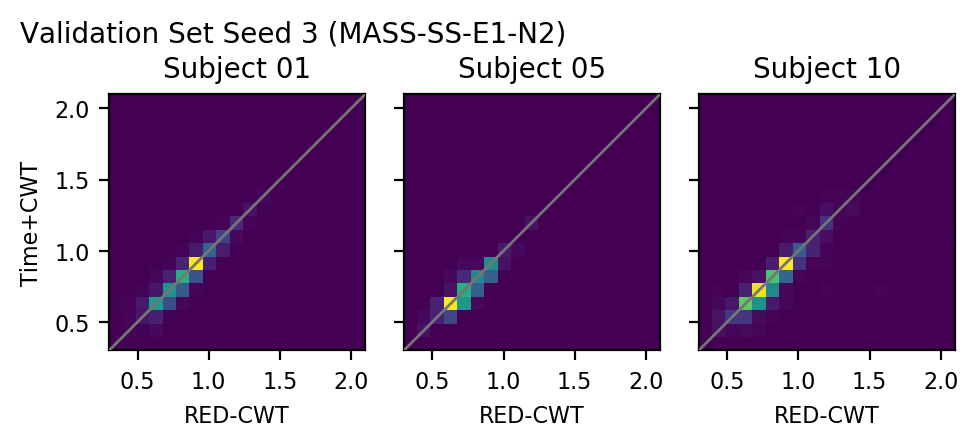

In [78]:
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('Seed %d' % chosen_seed)

dpi = 200
n_bins = 20
min_dur = 0.3
max_dur = 2.1
alpha_scatter = 0.2
plot_scatter = False
ticks = [0.5, 1.0, 1.5, 2.0]

x_bins = np.linspace(min_dur, max_dur, n_bins, endpoint=True)
y_bins = np.linspace(min_dur, max_dur, n_bins, endpoint=True)
x_centers = x_bins[:-1] + x_bins[1]/2 - x_bins[0]/2
y_centers = y_bins[:-1] + y_bins[1]/2 - y_bins[0]/2
xv, yv = np.meshgrid(x_centers, y_centers)
fig, ax = plt.subplots(2, 3, figsize=(5, 3.5), dpi=dpi)
for i, single_id in enumerate(val_ids):
    ax[0, i].set_title('Subject %02d' % single_id, fontsize=10)
    # Duration model 1 vs exp
    idx_matching = matching_data_1[i]['idx']
    data_x = events
    data_y = dets_1
    dur_x, dur_y = find_durations(data_x, data_y)
    dur_x, dur_y = dur_x / fs, dur_y / fs
    
    if plot_scatter:
        ax[0, i].scatter(dur_x, dur_y, alpha=alpha_scatter, color=viz.PALETTE['blue'])
    else:
        hist, _, _ = np.histogram2d(
            dur_x, dur_y, bins=[x_bins, y_bins], density=True)
        ax[0, i].hist2d(xv.flatten(), yv.flatten(), bins=[x_bins, y_bins], weights=hist.flatten(), cmap='viridis')
    if i == 0:
        ax[0, i].set_ylabel(model_1['name'], fontsize=viz.FONTSIZE_GENERAL)
    else:
        ax[0, i].set_yticklabels([])
    ax[0, i].set_xticklabels([])
    # Duration model 2 vs exp
    idx_matching = matching_data_2[i]['idx']
    data_x = events
    data_y = dets_2
    dur_x, dur_y = find_durations(data_x, data_y)
    dur_x, dur_y = dur_x / fs, dur_y / fs
    if plot_scatter:
        ax[1, i].scatter(dur_x, dur_y, alpha=alpha_scatter, color=viz.PALETTE['blue'])
    else:
        hist, _, _ = np.histogram2d(
            dur_x, dur_y, bins=[x_bins, y_bins], density=True)
        ax[1, i].hist2d(xv.flatten(), yv.flatten(), bins=[x_bins, y_bins], weights=hist.flatten(), cmap='viridis')
    if i == 0:
        ax[1, i].set_ylabel(model_2['name'], fontsize=viz.FONTSIZE_GENERAL)
    else:
        ax[1, i].set_yticklabels([])
    ax[1, i].set_xlabel('Expert', fontsize=viz.FONTSIZE_GENERAL)
    
for s_ax in ax.flatten():   
    s_ax.set_xlim([min_dur, max_dur])
    s_ax.set_ylim([min_dur, max_dur])
    s_ax.set_yticks(ticks)
    s_ax.set_xticks(ticks)
    s_ax.plot(
        [min_dur, max_dur], [min_dur, max_dur],
        linestyle='-', color=viz.GREY_COLORS[6], zorder=10, linewidth=1)
    s_ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    s_ax.set_aspect('equal')

plt.tight_layout()

plt.text(
    x=0.03, y=1.0, fontsize=10, 
    s='Validation Set Seed %d (%s)' % (
        chosen_seed, result_id), 
    ha="left", transform=fig.transFigure)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(5, 2), dpi=dpi)
for i, single_id in enumerate(val_ids):
    ax[i].set_title('Subject %02d' % single_id, fontsize=10)
    # Duration model 1 vs model_2
    idx_matching = matching_data_vs[i]['idx']
    data_x = dets_1
    data_y = dets_2
    xlabel = model_1['name']
    ylabel = model_2['name']
    dur_x, dur_y = find_durations(data_x, data_y)
    dur_x, dur_y = dur_x / fs, dur_y / fs
    if plot_scatter:
        ax[i].scatter(dur_x, dur_y, alpha=alpha_scatter, color=viz.PALETTE['blue'])
    else:
        hist, _, _ = np.histogram2d(
            dur_x, dur_y, bins=[x_bins, y_bins], density=True)
        ax[i].hist2d(xv.flatten(), yv.flatten(), bins=[x_bins, y_bins], weights=hist.flatten(), cmap='viridis')
    if i==0:
        ax[i].set_ylabel(ylabel, fontsize=viz.FONTSIZE_GENERAL)
    else:
        ax[i].set_yticklabels([])
    ax[i].set_xlabel(xlabel, fontsize=viz.FONTSIZE_GENERAL)
for s_ax in ax.flatten():   
    s_ax.set_xlim([min_dur, max_dur])
    s_ax.set_ylim([min_dur, max_dur])
    s_ax.set_yticks(ticks)
    s_ax.set_xticks(ticks)
    s_ax.plot(
        [min_dur, max_dur], [min_dur, max_dur],
        linestyle='-', color=viz.GREY_COLORS[6], zorder=10, linewidth=1)
    s_ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    s_ax.set_aspect('equal')

plt.tight_layout()
plt.text(
    x=0.03, y=1.0, fontsize=10, 
    s='Validation Set Seed %d (%s)' % (
        chosen_seed, result_id), 
    ha="left", transform=fig.transFigure)
plt.show()   

# F1 vs IoU versus

Database: mass_ss, Expert: 1
IoU to show: 0.2
Time+CWT wrt RED-CWT (MASS-SS-E1-N2) Val Set Seed 3
Subject 01 at IoU >= 0.2
F1 97.17 - Precision 97.81 - Recal 96.54
IoU of Matchings 95.24 [93.75 - 100.00]
Min IoU of matching: 0.47058823529411764
Subject 05 at IoU >= 0.2
F1 90.45 - Precision 89.64 - Recal 91.28
IoU of Matchings 94.16 [91.49 - 100.00]
Min IoU of matching: 0.6923076923076923
Subject 10 at IoU >= 0.2
F1 96.38 - Precision 96.38 - Recal 96.38
IoU of Matchings 94.17 [92.00 - 100.00]
Min IoU of matching: 0.48717948717948717


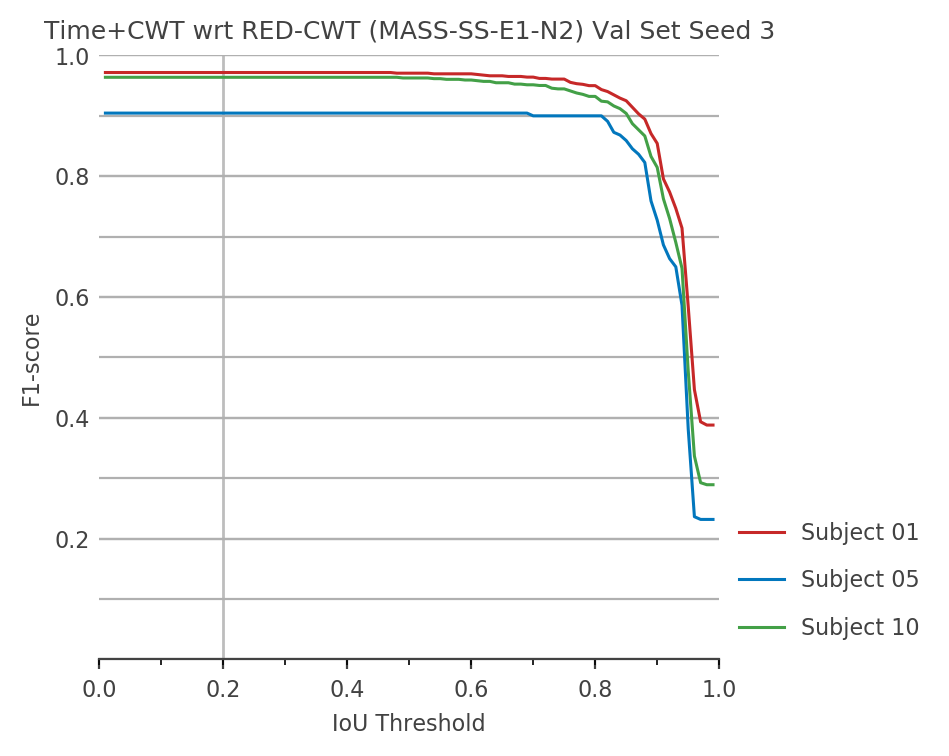

In [52]:
color_list = [viz.PALETTE['red'], viz.PALETTE['blue'], viz.PALETTE['green']]
marker_list = 3 * ['o']

# Plot f1 vs iou specs
smaller_plot = False
external_legend = True
iou_thr_to_show = 0.2
figsize = (4, 4)
title = '%s wrt %s (%s) Val Set Seed %d' % (model_2['name'], model_1['name'], result_id, chosen_seed)

# -------------------- P L O T ----------------------  
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print('IoU to show: %1.1f' % iou_thr_to_show)
print(title)
this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)
dense_iou = misc.custom_linspace(0.01, 0.99, 0.01)

for i, single_id in enumerate(val_ids):
    s_f1_curve = []
    iou_matching = matching_data_vs[i]['iou'][matching_data_vs[i]['idx'] != -1]
    n_detections = dets_2[i].shape[0]
    n_events = dets_1[i].shape[0]
    for single_iou in dense_iou:
        # Now, give credit only for iou >= iou_thr
        tp = np.sum((iou_matching >= single_iou).astype(int))
        fp = n_detections - tp
        fn = n_events - tp
        precision = tp / n_detections
        recall = tp / n_events
        f1_score = 2 * tp / (n_detections + n_events)
        s_f1_curve.append(f1_score)
        if np.abs(single_iou - 0.2) <= 1e-4:
            print('Subject %02d at IoU >= 0.2' % single_id)
            print('F1 %1.2f - Precision %1.2f - Recal %1.2f' % (
                f1_score * 100, precision * 100, recall * 100
            ))
            mean_iou = 100 * iou_matching.mean()
            low_iqr = 100 * np.percentile(iou_matching, 25)
            high_iqr = 100 * np.percentile(iou_matching, 75)
            print('IoU of Matchings %1.2f [%1.2f - %1.2f]' % (mean_iou, low_iqr, high_iqr))
            print('Min IoU of matching:', np.min(iou_matching))
    this_marker = marker_list[i]
    this_color = color_list[i]
    ax.plot(
        dense_iou, s_f1_curve, linewidth=viz.LINEWIDTH, zorder=10, 
        label='Subject %02d' % single_id, color=this_color
    )

ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')
ax = plotter.format_metric_vs_iou_plot(ax, 'F1-score', iou_thr_to_show)
lg = plotter.format_legend(ax, external_legend)
lg = plotter.set_legend_color(lg)
ax = plotter.set_axis_color(ax)
plt.show()

# Performance as a function of threshold

Database: mass_ss, Expert: 1
Time+CWT (MASS-SS-E1-N2) - val set Seed 3 IoU 0.2


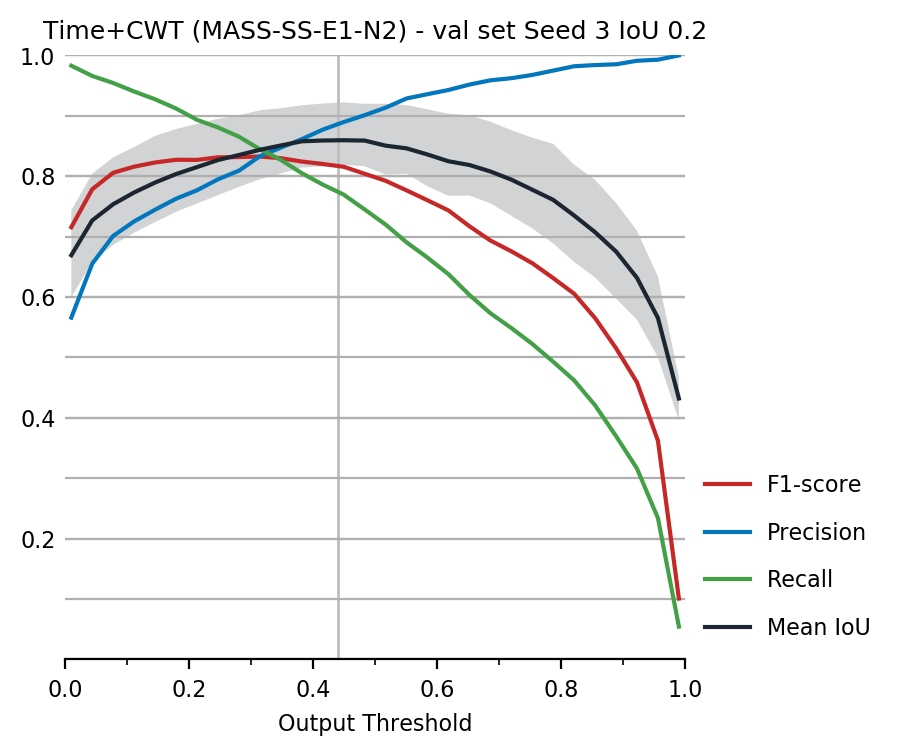

In [54]:
color_list = [viz.PALETTE['red'], viz.PALETTE['blue'], viz.PALETTE['green'], viz.PALETTE['dark']]
marker_list = 3 * ['o']
iou_to_show = 0.2
n_points = 30
model = model_2.copy()
preds = preds_2
opt_thr = opt_thr_2

# Plot f1 vs iou specs
smaller_plot = False
external_legend = True
show_iou_iqr = True
figsize = (4, 4)
title = '%s (%s) - %s set Seed %d IoU 0.2' % (model['name'], result_id, set_name, chosen_seed)

# -------------------- P L O T ----------------------  
print('Database: %s, Expert: %d' % (dataset_name, which_expert))
print(title)
this_dpi = 100 if smaller_plot else viz.DPI
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=this_dpi)
probas = preds.get_probabilities()
max_proba = np.min([s_p.max() for s_p in probas])
dense_thr = np.linspace(0.01, min([max_proba, 0.99]), n_points)
f1_evol = np.zeros((len(dense_thr), len(val_ids)))
prec_evol = np.zeros((len(dense_thr), len(val_ids)))
rec_evol = np.zeros((len(dense_thr), len(val_ids)))
iou_evol = np.zeros((len(dense_thr), len(val_ids)))
iou_evol_low_iqr = np.zeros((len(dense_thr), len(val_ids)))
iou_evol_high_iqr = np.zeros((len(dense_thr), len(val_ids)))
for j, s_thr in enumerate(dense_thr):
    preds.set_probability_threshold(s_thr)
    dets = preds.get_stamps()
    for i, single_id in enumerate(val_ids):
        s_events = events[i]
        s_dets = dets[i]
        s_iou_matching, s_idx_matching = metrics.matching(s_events, s_dets)
        iou_matching = s_iou_matching[s_idx_matching != -1]
        n_detections = s_dets.shape[0]
        n_events = s_events.shape[0]
        # Now, give credit only for iou >= iou_thr
        tp = np.sum((iou_matching >= iou_to_show).astype(int))
        fp = n_detections - tp
        fn = n_events - tp
        prec_evol[j, i] = tp / n_detections
        rec_evol[j, i] = tp / n_events
        f1_evol[j, i] = 2 * tp / (n_detections + n_events)
        iou_evol[j, i] = np.mean(iou_matching)
        iou_evol_low_iqr[j, i] = np.percentile(iou_matching, 25)
        iou_evol_high_iqr[j, i] = np.percentile(iou_matching, 75)
# Mean set
f1_evol = f1_evol.mean(axis=1)
prec_evol = prec_evol.mean(axis=1)
rec_evol = rec_evol.mean(axis=1)
iou_evol = iou_evol.mean(axis=1)
iou_evol_low_iqr = iou_evol_low_iqr.mean(axis=1)
iou_evol_high_iqr = iou_evol_high_iqr.mean(axis=1)

# Plots
linewidth = 1.5
ax.plot(dense_thr, f1_evol, label='F1-score', linewidth=linewidth, color=color_list[0], zorder=20)
ax.plot(dense_thr, prec_evol, label='Precision', linewidth=linewidth, color=color_list[1], zorder=20)
ax.plot(dense_thr, rec_evol, label='Recall', linewidth=linewidth, color=color_list[2], zorder=20)
ax.plot(dense_thr, iou_evol, label='Mean IoU', linewidth=linewidth, color=color_list[3], zorder=20)
if show_iou_iqr:
    ax.fill_between(
        dense_thr,
        iou_evol_low_iqr,
        iou_evol_high_iqr,
        facecolor=color_list[3], alpha=0.2
    )
    
ax.set_title(title, fontsize=viz.FONTSIZE_TITLE, loc='center')

ax.axvline(
    opt_thr,
    linestyle='-',
    color=viz.GREY_COLORS[4],
    zorder=1,
    linewidth=1)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_xticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticks(np.linspace(0.2, 1, 5))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.set_xlabel('Output Threshold', fontsize=viz.FONTSIZE_GENERAL)
# ax.set_ylabel('Metric', fontsize=viz.FONTSIZE_GENERAL)
ax.yaxis.grid(which='both')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='both', length=0)
lg = plotter.format_legend(ax, external_legend)
plt.show()

preds.set_probability_threshold(opt_thr)

# Stats of discrepancies

In [ ]:
def filter_stamps(stamps, start_sample, end_sample):
    pages_list = []
    for i in range(stamps.shape[0]):
        start_inside = (stamps[i, 0] > start_sample) and (stamps[i, 0] < end_sample)
        end_inside = (stamps[i, 1] > start_sample) and (stamps[i, 1] < end_sample)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list

In [ ]:
def mini_visual_versus(
    central_sample,
    signal_full, 
    true_stamp,
    det_stamp_1,
    det_stamp_2,
    proba_1,
    proba_2,
    optimal_thr_1,
    optimal_thr_2,
    name_1='Model 1',
    name_2='Model 2',
    title='',
    window_seconds=10,
    fs=200,
    max_voltage=100,
    dpi=80
):
    width_det = 30
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=dpi)
    expert_color = viz.PALETTE['green']
    model_1_color = viz.PALETTE['red']
    model_2_color = viz.PALETTE['blue']
    start_sample = int(central_sample - fs*window/2)
    end_sample = int(start_sample + window*fs)
    x_axis = np.arange(signal_full.size) / fs
    filt_exp = filter_stamps(s_events, start_sample, end_sample)
    filt_1 = filter_stamps(det_stamp_1, start_sample, end_sample)
    filt_2 = filter_stamps(det_stamp_2, start_sample, end_sample)
    # Signal+ expert
    ax.plot(
        x_axis[start_sample:end_sample], 
        np.clip(signal_full[start_sample:end_sample], -max_voltage, max_voltage), 
        linewidth=0.9, color=viz.PALETTE['dark'], zorder=20)
    for s_stamp in filt_exp:
        ax.fill_between(s_stamp/fs, -0.5*max_voltage, 0.5*max_voltage, facecolor=expert_color, alpha=0.5, zorder=10)
    # Model 1
    offset = -max_voltage - width_det*1.1
    ax.plot(
        x_axis[start_sample:end_sample][::8],
        offset + width_det*proba_1[start_sample//8:end_sample//8],
        linewidth=1.5, color=model_1_color, zorder=20, label=name_1)
    ax.plot(
        [start_sample/fs, end_sample/fs], 
        [offset+width_det*optimal_thr_1, offset+width_det*optimal_thr_1], 
        linewidth=1.1, color=viz.GREY_COLORS[8], zorder=30)
    ax.plot(
        [start_sample/fs, end_sample/fs], 
        [offset-0.1*width_det, offset-0.1*width_det], 
        linewidth=1.1, color=viz.GREY_COLORS[8], zorder=5)
    ax.plot(
        [start_sample/fs, end_sample/fs], 
        [offset+1.1*width_det, offset+1.1*width_det], 
        linewidth=1.1, color=viz.GREY_COLORS[8], zorder=5)
        
    for s_stamp in filt_1:
        ax.fill_between(s_stamp/fs, offset, offset+width_det, facecolor=model_1_color, alpha=0.5, zorder=10)
    # Model 2
    offset = -max_voltage - width_det*2.3
    ax.plot(
        x_axis[start_sample:end_sample][::8],
        offset + width_det*proba_2[start_sample//8:end_sample//8],
        linewidth=1.5, color=model_2_color, zorder=20, label=name_2)
    ax.plot(
        [start_sample/fs, end_sample/fs], 
        [offset+width_det*optimal_thr_2, offset+width_det*optimal_thr_2], 
        linewidth=1.1, color=viz.GREY_COLORS[8], zorder=30)
    for s_stamp in filt_2:
        ax.fill_between(s_stamp/fs, offset, offset+width_det, facecolor=model_2_color, alpha=0.5, zorder=10)
    ax.set_title(title, fontsize=10)
    ax.set_ylim([-max_voltage - width_det*2.4, max_voltage])
    ax.set_xlim([start_sample/fs, end_sample/fs])
    ax.set_yticks([-50, 0, 50])
    ax.set_xticks(start_sample/fs + np.arange(window_seconds), minor=True)
    ax.set_xticks([central_sample/fs])
    ax.legend(loc='upper left', ncol=2, fontsize=9)
    return ax

In [ ]:
print('Differences')
plot_differences = False
save_figs = False
for i, single_id in enumerate(val_ids):
    s_dets_1 = dets_1[i]
    s_dets_2 = dets_2[i]
    s_events = events[i]
    s_signal = signals[i]
    s_proba_1 = probas_1[i]
    s_proba_2 = probas_2[i]
    print("")
    print('Subject %02d (%d annotations)' % (single_id, s_events.shape[0]))
    
    # model_1 marco y model_2 no 
    # metrics.matching(events, detections)
    iou_matching, idx_matching = metrics.matching(s_dets_1, s_dets_2)
    m1_idx_different = np.where(idx_matching == -1)[0]
    iou_matching, idx_matching = metrics.matching(s_events, s_dets_1[m1_idx_different])
    subset_success_idx = idx_matching[idx_matching != -1]
    subset_failed_idx = [i for i in range(len(m1_idx_different)) if i not in subset_success_idx]
    m1_tp_m2_fn_idx = m1_idx_different[subset_success_idx]
    m1_fp_m2_tn_idx = m1_idx_different[subset_failed_idx]
    print('%s yes / %s no:'% (model_1['name'], model_2['name']))
    print('TP/FN: %d -- FP/TN: %d' % (m1_tp_m2_fn_idx.size, m1_fp_m2_tn_idx.size))
    # visualization
    if plot_differences:
        for this_idx in np.concatenate([m1_tp_m2_fn_idx, m1_fp_m2_tn_idx]):
            if this_idx in m1_tp_m2_fn_idx:
                title = '%s TP / %s FN (S%02d - %s - seed %d)' % (model_1['name'], model_2['name'], single_id, set_name, chosen_seed)
            elif this_idx in m1_fp_m2_tn_idx:
                title = '%s FP / %s TN (S%02d - %s - seed %d)' % (model_1['name'], model_2['name'], single_id, set_name, chosen_seed)
            else:
                raise ValueError()
            ax = mini_visual_versus(
                s_dets_1[this_idx].mean(),
                s_signal, s_events,
                s_dets_1, s_dets_2,
                s_proba_1, s_proba_2,
                opt_thr_1, opt_thr_2,
                name_1=model_1['name'], name_2=model_2['name'],
                title=title,
                window_seconds=10,
                fs=200,
                max_voltage=100,
                dpi=120)
            if save_figs:
                plt.savefig("%s_seed%d_s%02d_m1yes_m2no_idx%d.png" % (
                    set_name, chosen_seed, single_id, this_idx
                ))
            plt.show()
        
    # model_1 no marco y model_2 si 
    # metrics.matching(events, detections)
    iou_matching, idx_matching = metrics.matching(s_dets_2, s_dets_1)
    m2_idx_different = np.where(idx_matching == -1)[0]
    iou_matching, idx_matching = metrics.matching(s_events, s_dets_2[m2_idx_different])
    subset_success_idx = idx_matching[idx_matching != -1]
    subset_failed_idx = [i for i in range(len(m1_idx_different)) if i not in subset_success_idx]
    m1_fn_m2_tp_idx = m2_idx_different[subset_success_idx]
    m1_tn_m2_fp_idx = m2_idx_different[subset_failed_idx]
    print('%s no / %s yes:'% (model_1['name'], model_2['name']))
    print('FN/TP: %d -- TN/FP: %d' % (m1_fn_m2_tp_idx.size, m1_tn_m2_fp_idx.size))
    # visualization
    if plot_differences:
        for this_idx in np.concatenate([m1_fn_m2_tp_idx, m1_tn_m2_fp_idx]):
            if this_idx in m1_fn_m2_tp_idx:
                title = '%s FN / %s TP (S%02d - %s - seed %d)' % (model_1['name'], model_2['name'], single_id, set_name, chosen_seed)
            elif this_idx in m1_tn_m2_fp_idx:
                title = '%s TN / %s FP (S%02d - %s - seed %d)' % (model_1['name'], model_2['name'], single_id, set_name, chosen_seed)
            else:
                raise ValueError()
            ax = mini_visual_versus(
                s_dets_2[this_idx].mean(),
                s_signal, s_events,
                s_dets_1, s_dets_2,
                s_proba_1, s_proba_2,
                opt_thr_1, opt_thr_2,
                name_1=model_1['name'], name_2=model_2['name'],
                title=title,
                window_seconds=10,
                fs=200,
                max_voltage=100,
                dpi=120)
            if save_figs:
                plt.savefig("%s_seed%d_s%02d_m1no_m2yes_idx%d.png" % (
                    set_name, chosen_seed, single_id, this_idx
                ))
            plt.show()


# Some particular errors (FP, FN, low IoU)

In [ ]:
iou_low_thr = 0.6
n_samples = 4
save_figs = False
for i, single_id in enumerate(val_ids):
    s_dets_1 = dets_1[i]
    s_dets_2 = dets_2[i]
    s_events = events[i]
    s_signal = signals[i]
    s_proba_1 = probas_1[i]
    s_proba_2 = probas_2[i]
    print("")
    print('Subject %02d (%d annotations)' % (single_id, s_events.shape[0]))
    iou_matching, idx_matching = metrics.matching(s_events, s_dets_2)
    # FN indices
    fn_idx = np.where(idx_matching == -1)[0]
    fn_stamps = s_events[fn_idx]
    fn_central_samples = fn_stamps.mean(axis=1).astype(np.int32)
    print('FN: %d' % fn_central_samples.size)
    fn_chosen_centers = np.random.choice(fn_central_samples, size=n_samples, replace=False)   
    # low IoU indices
    low_iou_idx = np.where(((iou_matching < iou_low_thr) & (idx_matching !=-1)))[0]
    low_iou_stamps = s_events[low_iou_idx]
    low_iou_central_samples = low_iou_stamps.mean(axis=1).astype(np.int32)
    print('Low IoU: %d' % low_iou_central_samples.size)
    low_iou_chosen_centers = np.random.choice(low_iou_central_samples, size=n_samples, replace=False)  
    # FP indices
    fp_idx = [i for i in range(s_dets_2.shape[0]) if i not in idx_matching]
    fp_stamps = s_dets_2[fp_idx]
    fp_central_samples = fp_stamps.mean(axis=1).astype(np.int32)
    print('FP %d' % fp_central_samples.size)
    fp_chosen_centers = np.random.choice(fp_central_samples, size=n_samples, replace=False)  
    
    all_centers = np.concatenate([fn_chosen_centers, low_iou_chosen_centers, fp_chosen_centers])
    
    print(all_centers)
    if all_centers.size != np.unique(all_centers).size:
        raise ValueError()

    for this_center in all_centers:
        if this_center in fn_chosen_centers:
            title = '%s FN (S%02d - %s - seed %d)' % (model_2['name'], single_id, set_name, chosen_seed)
            fname = '%s_fn_s%02d_%s_seed%d_%d' % (model_2['name'], single_id, set_name, chosen_seed, this_center)
        elif this_center in low_iou_chosen_centers:
            title = '%s low IoU (S%02d - %s - seed %d)' % (model_2['name'], single_id, set_name, chosen_seed)
            fname = '%s_low_iou_s%02d_%s_seed%d_%d' % (model_2['name'], single_id, set_name, chosen_seed, this_center)
        elif this_center in fp_chosen_centers:
            title = '%s FP (S%02d - %s - seed %d)' % (model_2['name'], single_id, set_name, chosen_seed)
            fname = '%s_fp_s%02d_%s_seed%d_%d' % (model_2['name'], single_id, set_name, chosen_seed, this_center)
        else:
            raise ValueError()
        ax = mini_visual_versus(
            this_center,
            s_signal, s_events,
            s_dets_1, s_dets_2,
            s_proba_1, s_proba_2,
            opt_thr_1, opt_thr_2,
            name_1=model_1['name'], name_2=model_2['name'],
            title=title,
            window_seconds=10,
            fs=200,
            max_voltage=100,
            dpi=120)
        if save_figs:
            plt.savefig(fname)
        plt.show()
    